# VectorEmbeddingService Test Results

This notebook tests the intent classification API routes against multiple prompts to evaluate performance and latency.

## API Routes Tested
- `/api/intent/embedding` - Vector embedding-based classification (now returns `durationMs`)
- `/api/intent/slm` - Small Language Model classification (classification payload includes `durationMs`)
- `/api/intent/hybrid` - Hybrid approach (vector + SLM, both expose timing metadata)


## Setup

Load test prompts and import required libraries.


In [1]:
%pip install --upgrade pip
%pip install requests tqdm seaborn pandas


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tqdm import tqdm

    
# Load test prompts from data/testPrompts.json
# Each prompt has {intent, text} structure
prompts_path = Path('data') / 'testPrompts.json'

# If not found, try absolute path from current working directory
if not prompts_path.exists():
    import os
    project_root = Path(os.getcwd())
    prompts_path = project_root / 'data' / 'testPrompts.json'

with open(prompts_path, 'r', encoding='utf-8') as f:
    prompts_data = json.load(f)
    test_prompts = prompts_data['testPrompts']

print(f"Loaded {len(test_prompts)} test prompts from {prompts_path}")
print(f"Prompts structure: {{intent, text}}")

Loaded 240 test prompts from data/testPrompts.json
Prompts structure: {intent, text}


## Test Functions

Functions to test each API route.


In [3]:
def test_embedding_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/embedding') -> List[Dict[str, Any]]:
    """Test the embedding API route."""
    results = []
    start_time = time.time()
    api_durations: List[float] = []
    
    for prompt_obj in tqdm(prompts, desc="Testing Embedding API", unit="prompt"):
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')
        
        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=10
            )
            response.raise_for_status()
            
            data = response.json()
            intent_obj = data.get('intent') or {}
            actual_intent = intent_obj.get('intent', 'N/A')
            if actual_intent == 'toFallback':
                continue
            
            duration_ms = data.get('durationMs')
            if isinstance(duration_ms, (int, float)):
                api_durations.append(duration_ms)
            
            is_correct = None
            if expected_intent:
                is_correct = actual_intent == expected_intent
            
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'predictedIntent': actual_intent,
                'isCorrect': is_correct,
                'score': intent_obj.get('score', 0),
                'candidates': data.get('candidates', []),
                'durationMs': duration_ms,
                'route': 'embedding'
            })
        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'embedding',
                'durationMs': None
            })
        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'embedding',
                'durationMs': None
            })
    # End timer
    total_time = time.time() - start_time
    print(f"\nTotal time: {total_time:.2f} seconds for {len(prompts)} prompts")
    
    if api_durations:
        duration_array = np.array(api_durations)
        print(
            "Average API duration: "
            f"{duration_array.mean():.2f} ms "
            f"(median {np.median(duration_array):.2f} ms, p95 {np.percentile(duration_array, 95):.2f} ms)"
        )
    
    return results

print("Embedding API test function defined")

Embedding API test function defined


In [4]:
def test_slm_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/slm') -> List[Dict[str, Any]]:
    """Test the SLM API route with a progress bar and total runtime."""
    
    results = []
    start_time = time.time()
    api_durations: List[float] = []

    # tqdm progress bar
    for prompt_obj in tqdm(prompts, desc="Testing SLM API", unit="prompt"):
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')

        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=30
            )
            response.raise_for_status()

            data = response.json()
            classification = data.get('classification', {})
            actual_intent = classification.get('intent', 'N/A')
            duration_ms = classification.get('durationMs')
            params = classification.get('params', None)
            if isinstance(duration_ms, (int, float)):
                api_durations.append(duration_ms)
            is_correct = None

            if expected_intent:
                is_correct = actual_intent == expected_intent

            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'predictedIntent': actual_intent,
                'isCorrect': is_correct,
                'classification': classification,
                'params': params,
                'durationMs': duration_ms,
                'route': 'slm'
            })

        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'slm',
                'durationMs': None
            })

        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'slm',
                'durationMs': None
            })

    # End timer
    total_time = time.time() - start_time
    print(f"\nTotal time: {total_time:.2f} seconds for {len(prompts)} prompts")

    if api_durations:
        duration_array = np.array(api_durations)
        print(
            "Average API duration: "
            f"{duration_array.mean():.2f} ms "
            f"(median {np.median(duration_array):.2f} ms, p95 {np.percentile(duration_array, 95):.2f} ms)"
        )

    return results

print("SLM API test function defined")

SLM API test function defined


In [5]:
def test_hybrid_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/hybrid') -> List[Dict[str, Any]]:
    """Test the hybrid API route."""
    results = []
    vector_durations: List[float] = []
    slm_durations: List[float] = []
    start_time = time.time()
    
    for prompt_obj in prompts:
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')
        
        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=30
            )
            response.raise_for_status()
            
            data = response.json()
            vector_matches = data.get('vectorMatches', [])
            slm_result = data.get('slm', {})
            vector_duration = data.get('vectorDurationMs')
            slm_duration = slm_result.get('durationMs')
            if isinstance(vector_duration, (int, float)):
                vector_durations.append(vector_duration)
            if isinstance(slm_duration, (int, float)):
                slm_durations.append(slm_duration)
            
            # Get intents from both approaches
            vector_intent = vector_matches[0].get('intent', 'N/A') if vector_matches else 'N/A'
            slm_intent = slm_result.get('intent', 'N/A')
            
            # Use SLM intent as primary (hybrid approach)
            actual_intent = slm_intent if slm_intent != 'N/A' else vector_intent
            is_correct = None
            if expected_intent:
                is_correct = actual_intent == expected_intent
            
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'predictedIntent': actual_intent,
                'vectorIntent': vector_intent,
                'slmIntent': slm_intent,
                'isCorrect': is_correct,
                'vectorMatches': vector_matches,
                'slmResult': slm_result,
                'vectorDurationMs': vector_duration,
                'slmDurationMs': slm_duration,
                'route': 'hybrid'
            })
        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'hybrid',
                'vectorDurationMs': None,
                'slmDurationMs': None
            })
        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'hybrid',
                'vectorDurationMs': None,
                'slmDurationMs': None
            })
    
    total_time = time.time() - start_time
    print(f"\nTotal time: {total_time:.2f} seconds for {len(prompts)} prompts")
    
    if vector_durations:
        vec_arr = np.array(vector_durations)
        print(
            "Vector duration stats: "
            f"avg {vec_arr.mean():.2f} ms | median {np.median(vec_arr):.2f} ms | p95 {np.percentile(vec_arr, 95):.2f} ms"
        )
    if slm_durations:
        slm_arr = np.array(slm_durations)
        print(
            "SLM duration stats: "
            f"avg {slm_arr.mean():.2f} ms | median {np.median(slm_arr):.2f} ms | p95 {np.percentile(slm_arr, 95):.2f} ms"
        )
    
    return results

print("Hybrid API test function defined")

Hybrid API test function defined


## Analysis Functions

Functions to analyze and display test results.


In [6]:
def analyze_results(results: List[Dict[str, Any]], route_name: str = '') -> Dict[str, Any]:
    """Analyze and display test results with accuracy metrics and latency stats."""
    route_label = f" ({route_name})" if route_name else ""
    
    success_count = 0
    error_count = 0
    correct_count = 0
    incorrect_count = 0
    intent_distribution = {}
    accuracy_by_intent = {}
    latency_values: List[float] = []
    
    for idx, result in enumerate(results, 1):
        duration_ms = result.get('durationMs')
        if isinstance(duration_ms, (int, float)):
            latency_values.append(duration_ms)
        
        if 'error' in result:
            error_count += 1
        else:
            expected = result.get('expectedIntent', 'N/A')
            actual = result.get('predictedIntent', 'N/A')
            is_correct = result.get('isCorrect')
            
            if expected and expected != 'N/A':
                if is_correct is True:
                    correct_count += 1
                elif is_correct is False:
                    incorrect_count += 1
            
            # Track intent distribution
            if actual != 'N/A':
                intent_distribution[actual] = intent_distribution.get(actual, 0) + 1
            
            # Track accuracy by expected intent
            if expected and expected != 'N/A' and is_correct is not None:
                if expected not in accuracy_by_intent:
                    accuracy_by_intent[expected] = {'correct': 0, 'total': 0}
                accuracy_by_intent[expected]['total'] += 1
                if is_correct:
                    accuracy_by_intent[expected]['correct'] += 1
            
            success_count += 1
    
    print('\n=== SUMMARY STATISTICS ===')
    print(f'Total Prompts: {len(results)}')
    print(f'Successful: {success_count}')
    print(f'Errors: {error_count}')
    
    if correct_count + incorrect_count > 0:
        accuracy = (correct_count / (correct_count + incorrect_count) * 100)
        print(f'\nAccuracy: {correct_count}/{correct_count + incorrect_count} ({accuracy:.2f}%)')
        print(f'  Correct: {correct_count}')
        print(f'  Incorrect: {incorrect_count}')
    else:
        accuracy = None
    
    print(f'\nIntent Distribution (Predicted):')
    for intent, count in sorted(intent_distribution.items(), key=lambda x: x[1], reverse=True):
        print(f'  {intent}: {count}')
    
    if accuracy_by_intent:
        print(f'\nAccuracy by Intent:')
        for intent, stats in sorted(accuracy_by_intent.items()):
            acc = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            print(f'  {intent}: {stats["correct"]}/{stats["total"]} ({acc:.2f}%)')
    
    latency_summary = None
    if latency_values:
        latency_array = np.array(latency_values)
        latency_summary = {
            'avgMs': float(latency_array.mean()),
            'medianMs': float(np.median(latency_array)),
            'p95Ms': float(np.percentile(latency_array, 95)),
            'count': len(latency_array)
        }
        print('\nLatency (durationMs reported by API):')
        print(
            f"  avg {latency_summary['avgMs']:.2f} ms | "
            f"median {latency_summary['medianMs']:.2f} ms | "
            f"p95 {latency_summary['p95Ms']:.2f} ms"
        )
    
    return {
        'total': len(results),
        'successful': success_count,
        'errors': error_count,
        'correct': correct_count,
        'incorrect': incorrect_count,
        'accuracy': accuracy,
        'intent_distribution': intent_distribution,
        'accuracy_by_intent': accuracy_by_intent,
        'latency_summary': latency_summary
    }

print("Results analysis function defined")

Results analysis function defined


## Run Tests

Execute tests against all API routes. Make sure your Next.js server is running: `npm run dev`


In [40]:
# Test Embedding API
print("Testing Embedding API...")
embedding_results = test_embedding_api(test_prompts)
embedding_summary = analyze_results(embedding_results, 'Embedding')

# Store results
embedding_test_data = {
    'results': embedding_results,
    'summary': embedding_summary,
    'timestamp': datetime.now().isoformat(),
    'route': 'embedding'
}


Testing Embedding API...


Testing Embedding API: 100%|██████████████| 240/240 [00:12<00:00, 19.56prompt/s]


Total time: 12.27 seconds for 240 prompts
Average API duration: 40.29 ms (median 22.00 ms, p95 40.00 ms)

=== SUMMARY STATISTICS ===
Total Prompts: 219
Successful: 219
Errors: 0

Accuracy: 144/219 (65.75%)
  Correct: 144
  Incorrect: 75

Intent Distribution (Predicted):
  product_search: 40
  bulk_or_budget_search: 34
  price_query: 27
  comparison_search: 25
  navigation: 25
  project_based_search: 24
  problem_solving_search: 23
  navigation_with_parameters: 21

Accuracy by Intent:
  bulk_or_budget_search: 22/30 (73.33%)
  comparison_search: 19/30 (63.33%)
  navigation: 19/22 (86.36%)
  navigation_with_parameters: 17/26 (65.38%)
  price_query: 13/27 (48.15%)
  problem_solving_search: 18/30 (60.00%)
  product_search: 20/25 (80.00%)
  project_based_search: 16/29 (55.17%)

Latency (durationMs reported by API):
  avg 40.29 ms | median 22.00 ms | p95 40.00 ms


In [46]:
# Test SLM API
print("Testing SLM API...")
slm_results = test_slm_api(test_prompts)
slm_summary = analyze_results(slm_results, 'SLM')

# Store results
slm_test_data = {
    'results': slm_results,
    'summary': slm_summary,
    'timestamp': datetime.now().isoformat(),
    'route': 'slm'
}


Testing SLM API...


Testing SLM API: 100%|████████████████████| 240/240 [12:49<00:00,  3.21s/prompt]


Total time: 769.51 seconds for 240 prompts
Average API duration: 3141.31 ms (median 3102.50 ms, p95 3900.75 ms)

=== SUMMARY STATISTICS ===
Total Prompts: 240
Successful: 236
Errors: 4

Accuracy: 194/236 (82.20%)
  Correct: 194
  Incorrect: 42

Intent Distribution (Predicted):
  product_search: 43
  bulk_or_budget_search: 33
  price_query: 32
  navigation_with_parameters: 29
  project_based_search: 28
  comparison_search: 27
  problem_solving_search: 22
  navigation: 21
  unknown: 1

Accuracy by Intent:
  bulk_or_budget_search: 26/30 (86.67%)
  comparison_search: 25/30 (83.33%)
  navigation: 21/29 (72.41%)
  navigation_with_parameters: 21/30 (70.00%)
  price_query: 28/29 (96.55%)
  problem_solving_search: 19/29 (65.52%)
  product_search: 29/29 (100.00%)
  project_based_search: 25/30 (83.33%)

Latency (durationMs reported by API):
  avg 3141.31 ms | median 3102.50 ms | p95 3900.75 ms


### Log Results

- Prompt
- Response Time
- Expected vs Predicted
- Confidence Level

In [66]:
# # Test Hybrid API
# print("Testing Hybrid API...")
# hybrid_results = test_hybrid_api(test_prompts)
# hybrid_summary = analyze_results(hybrid_results, 'Hybrid')

# # Store results
# hybrid_test_data = {
#     'results': hybrid_results,
#     'summary': hybrid_summary,
#     'timestamp': datetime.now().isoformat(),
#     'route': 'hybrid'
# }
slm_results

[{'text': 'cemento holcim 50kg',
  'expectedIntent': 'product_search',
  'predictedIntent': 'product_search',
  'isCorrect': True,
  'classification': {'intent': 'product_search',
   'confidence': 1,
   'params': {'brand': 'Holcim', 'material': 'cement', 'size': '50kg'},
   'durationMs': 9057},
  'durationMs': 9057,
  'route': 'slm'},
 {'text': 'tubería pvc 2 pulgadas',
  'expectedIntent': 'product_search',
  'predictedIntent': 'product_search',
  'isCorrect': True,
  'classification': {'intent': 'product_search',
   'confidence': 1,
   'params': {'brand': '', 'size': '2 inches', 'material': 'PVC pipe'},
   'durationMs': 3395},
  'durationMs': 3395,
  'route': 'slm'},
 {'text': 'tubería pvc 1 pulgada para agua potable',
  'expectedIntent': 'product_search',
  'predictedIntent': 'product_search',
  'isCorrect': True,
  'classification': {'intent': 'product_search',
   'confidence': 0.95,
   'params': {'material': 'PVC',
    'size': '1 inch',
    'purpose': 'water supply for drinking wat

## Compare Results

Compare performance across all three API routes.


In [48]:
# Compare all routes
print("\n=== ROUTE COMPARISON ===\n")

routes = [
    ('Embedding', embedding_summary),
    ('SLM', slm_summary)
]

print(f"{'Route':<15} {'Accuracy':<15} {'Correct':<10} {'Incorrect':<12} {'Errors':<10}")
print("-" * 65)

for route_name, summary in routes:
    accuracy = summary.get('accuracy')
    accuracy_str = f"{accuracy:.2f}%" if accuracy is not None else "N/A"
    correct = summary.get('correct', 0)
    incorrect = summary.get('incorrect', 0)
    errors = summary.get('errors', 0)
    
    print(f"{route_name:<15} {accuracy_str:<15} {correct:<10} {incorrect:<12} {errors:<10}")

# Find best route
best_route = max(routes, key=lambda x: x[1].get('accuracy', 0) if x[1].get('accuracy') is not None else 0)
print(f"\nBest performing route: {best_route[0]} ({best_route[1].get('accuracy', 0):.2f}% accuracy)")


=== ROUTE COMPARISON ===

Route           Accuracy        Correct    Incorrect    Errors    
-----------------------------------------------------------------
Embedding       65.75%          144        75           0         
SLM             82.20%          194        42           4         

Best performing route: SLM (82.20% accuracy)


## Export Results

Export test results to JSON files for further analysis.


In [49]:
def export_results(results: List[Dict[str, Any]], summary: Dict[str, Any], filename: str):
    """Export test results to JSON file."""
    output = {
        'timestamp': datetime.now().isoformat(),
        'total_prompts': len(results),
        'results': results,
        'summary': summary
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output, f, indent=2, ensure_ascii=False)
    
    print(f' Results exported to {filename}')
    return output

# Export all results
# Uncomment to export
# export_results(embedding_results, embedding_summary, 'embedding_test_results.json')
# export_results(slm_results, slm_summary, 'slm_test_results.json')
# export_results(hybrid_results, hybrid_summary, 'hybrid_test_results.json')

# Export combined comparison
# combined_output = {
#     'timestamp': datetime.now().isoformat(),
#     'embedding': embedding_test_data,
#     'slm': slm_test_data,
#     'hybrid': hybrid_test_data
# }
# with open('all_routes_test_results.json', 'w', encoding='utf-8') as f:
#     json.dump(combined_output, f, indent=2, ensure_ascii=False)
# print(' Combined results exported to all_routes_test_results.json')


## Detailed Analysis with Pandas

Display results in tabular format (optional, requires pandas).


In [50]:
   
# Create DataFrame for embedding results
df_embedding = pd.DataFrame([
    {
        'text': r.get('text', 'N/A'),
        'expected_intent': r.get('expectedIntent', 'N/A'),
        'predicted_intent': r.get('predictedIntent', 'N/A'),
        'is_correct': r.get('isCorrect'),
        'score': r.get('score', 0),
        'error': r.get('error', '')
    }
    for r in embedding_results
])

print("\n=== EMBEDDING RESULTS TABLE ===")
display(df_embedding[df_embedding["is_correct"] == False])





=== EMBEDDING RESULTS TABLE ===


,text,expected_intent,predicted_intent,is_correct,score,error
6,pintura esmalte negro,product_search,comparison_search,False,0.732382,
7,bloques de hormigón 15x20x40,product_search,price_query,False,0.724716,
8,cinta masking para pintura,product_search,bulk_or_budget_search,False,0.738425,
9,tubo hdpe 32mm,product_search,price_query,False,0.831191,
22,cemento portland tipo I 50kg,product_search,price_query,False,0.852669,
...,...,...,...,...,...,...
206,facturas mayores a 100 dólares,navigation_with_parameters,product_search,False,0.676170,
208,ver productos tamaño 60x60,navigation_with_parameters,price_query,False,0.701577,
209,pedidos del mes de enero,navigation_with_parameters,navigation,False,0.754701,
211,mostrar pedidos entre fechas,navigation_with_parameters,navigation,False,0.826947,


In [67]:
   
# Create DataFrame for SLM results
df_slm = pd.DataFrame([
    {
        'text': r.get('text', 'N/A'),
        'expected_intent': r.get('expectedIntent', 'N/A'),
        'predicted_intent': r.get('predictedIntent', 'N/A'),
        'is_correct': r.get('isCorrect'),
        'score': r.get('score', 0),
        'error': r.get('error', ''),
        'raw_result': r.get('classification', '')
    }
    for r in slm_results
])

print("\n=== SLM RESULTS TABLE ===")
display(df_slm[df_slm["is_correct"] == False])




=== SLM RESULTS TABLE ===


,text,expected_intent,predicted_intent,is_correct,score,error,raw_result
30,estoy buscando algo 60x60 antideslizante para ...,problem_solving_search,product_search,False,0,,"{'intent': 'product_search', 'confidence': 0.9..."
31,"pintura blanca barata… pero que sea lavable, ¿...",problem_solving_search,bulk_or_budget_search,False,0,,"{'intent': 'bulk_or_budget_search', 'confidenc..."
32,tubería 1 pulgada… ¿pero cuál sirve para calie...,problem_solving_search,comparison_search,False,0,,"{'intent': 'comparison_search', 'confidence': ..."
39,"aislar ruido sin gastar mucho, ¿qué material s...",problem_solving_search,bulk_or_budget_search,False,0,,"{'intent': 'bulk_or_budget_search', 'confidenc..."
44,aislamiento acústico para paredes delgadas,problem_solving_search,product_search,False,0,,"{'intent': 'product_search', 'confidence': 0.9..."
50,material para impermeabilizar terraza y tambié...,problem_solving_search,bulk_or_budget_search,False,0,,"{'intent': 'bulk_or_budget_search', 'confidenc..."
52,producto para paredes húmedas,problem_solving_search,product_search,False,0,,"{'intent': 'product_search', 'confidence': 0.9..."
55,material para terrazza impermeabilização,problem_solving_search,product_search,False,0,,"{'intent': 'product_search', 'confidence': 1, ..."
57,precio de pintura y cuál dura más en interior ...,problem_solving_search,price_query,False,0,,"{'intent': 'price_query', 'confidence': 0.9, '..."
59,quiero material para nivelar un piso súper des...,problem_solving_search,product_search,False,0,,"{'intent': 'product_search', 'confidence': 0.8..."


In [14]:
# Set a nice style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')

In [52]:
# Create comparison DataFrame
comparison_data = []
for i, prompt_obj in enumerate(test_prompts):
    text = prompt_obj.get('text', '')
    expected = prompt_obj.get('intent', 'N/A')

    embedding_result = embedding_results[i] if i < len(embedding_results) else {}
    slm_result = slm_results[i] if i < len(slm_results) else {}

    comparison_data.append({
        'text': text[:50] + '...' if len(text) > 50 else text,
        'expected': expected,
        'embedding': embedding_result.get('actualIntent', 'N/A'),
        'slm': slm_result.get('predictedIntent', 'N/A'),
        'embedding_correct': embedding_result.get('isCorrect'),
        'slm_correct': slm_result.get('isCorrect'),
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n=== ROUTE COMPARISON TABLE ===")
display(df_comparison)


=== ROUTE COMPARISON TABLE ===


,text,expected,embedding,slm,embedding_correct,slm_correct
0,cemento holcim 50kg,product_search,N/A,product_search,True,True
1,tubería pvc 2 pulgadas,product_search,N/A,product_search,True,True
2,tubería pvc 1 pulgada para agua potable,product_search,N/A,product_search,True,True
3,plancha de yeso 1/2,product_search,N/A,product_search,True,True
4,porcelanato 60x60 beige,product_search,N/A,product_search,True,True
...,...,...,...,...,...,...
235,muéstrame las facturas entre 5 mayo y 18 junio...,navigation_with_parameters,N/A,navigation_with_parameters,None,True
236,quiero ver productos categoría 'herramientas' ...,navigation_with_parameters,N/A,bulk_or_budget_search,None,False
237,open invoices from last year solo las pendient...,navigation_with_parameters,N/A,navigation_with_parameters,None,True
238,cotizaciones entre enero-marzo y filtradas por...,navigation_with_parameters,N/A,navigation_with_parameters,None,True


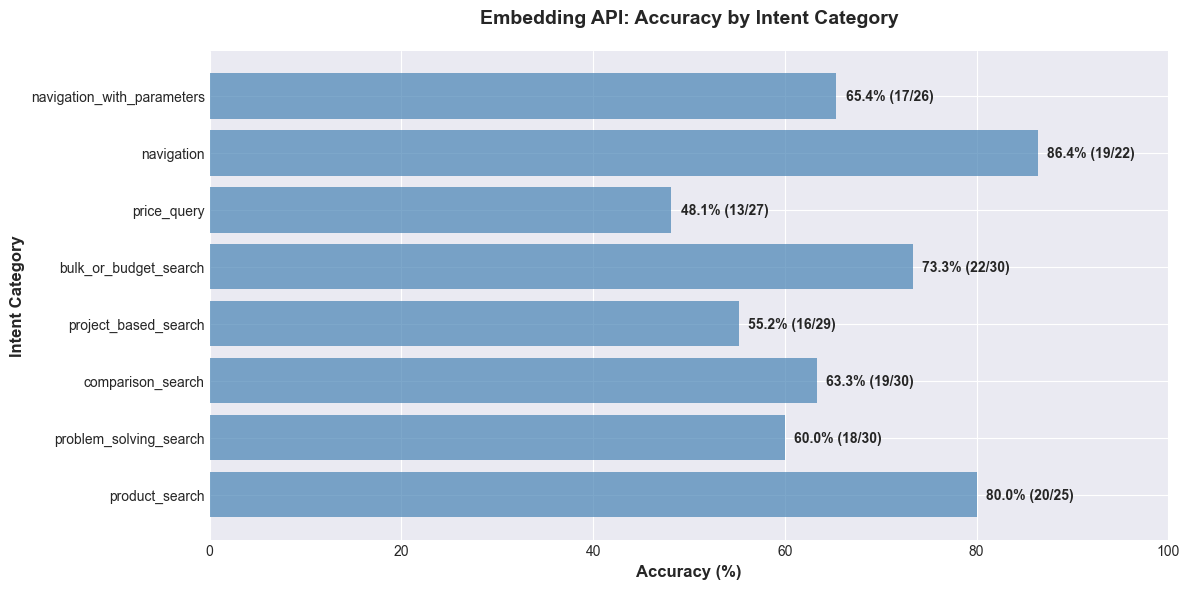

In [53]:
   
# ========== MATPLOTLIB VISUALIZATIONS ==========

# 1. Accuracy by Intent (Embedding)
if embedding_summary.get('accuracy_by_intent'):
    fig, ax = plt.subplots(figsize=(12, 6))
    intent_data = embedding_summary['accuracy_by_intent']
    intents = list(intent_data.keys())
    accuracies = [(intent_data[i]['correct'] / intent_data[i]['total'] * 100) 
                 if intent_data[i]['total'] > 0 else 0 for i in intents]
    totals = [intent_data[i]['total'] for i in intents]

    bars = ax.barh(intents, accuracies, color='steelblue', alpha=0.7)
    ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Intent Category', fontsize=12, fontweight='bold')
    ax.set_title('Embedding API: Accuracy by Intent Category', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 100)

    # Add value labels on bars
    for i, (bar, acc, total) in enumerate(zip(bars, accuracies, totals)):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
               f'{acc:.1f}% ({intent_data[intents[i]]["correct"]}/{total})',
               ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    


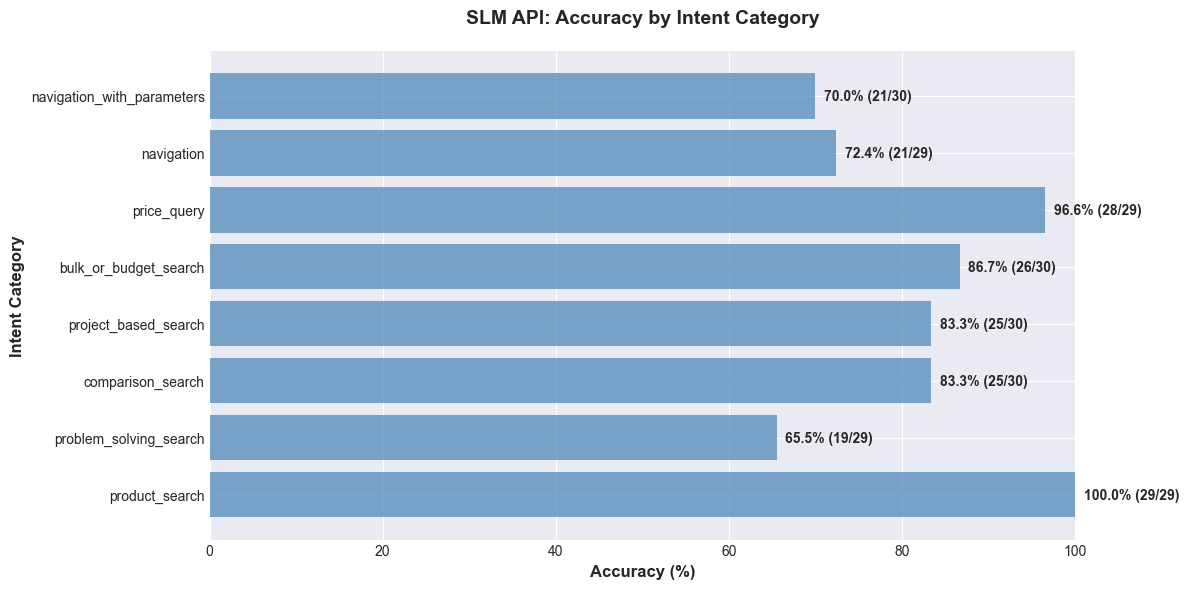

In [54]:

# Accuracy by Intent (SLM)
if slm_summary.get('accuracy_by_intent'):
    fig, ax = plt.subplots(figsize=(12, 6))
    intent_data = slm_summary['accuracy_by_intent']
    intents = list(intent_data.keys())
    accuracies = [(intent_data[i]['correct'] / intent_data[i]['total'] * 100) 
                 if intent_data[i]['total'] > 0 else 0 for i in intents]
    totals = [intent_data[i]['total'] for i in intents]

    bars = ax.barh(intents, accuracies, color='steelblue', alpha=0.7)
    ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Intent Category', fontsize=12, fontweight='bold')
    ax.set_title('SLM API: Accuracy by Intent Category', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 100)

    # Add value labels on bars
    for i, (bar, acc, total) in enumerate(zip(bars, accuracies, totals)):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
               f'{acc:.1f}% ({intent_data[intents[i]]["correct"]}/{total})',
               ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

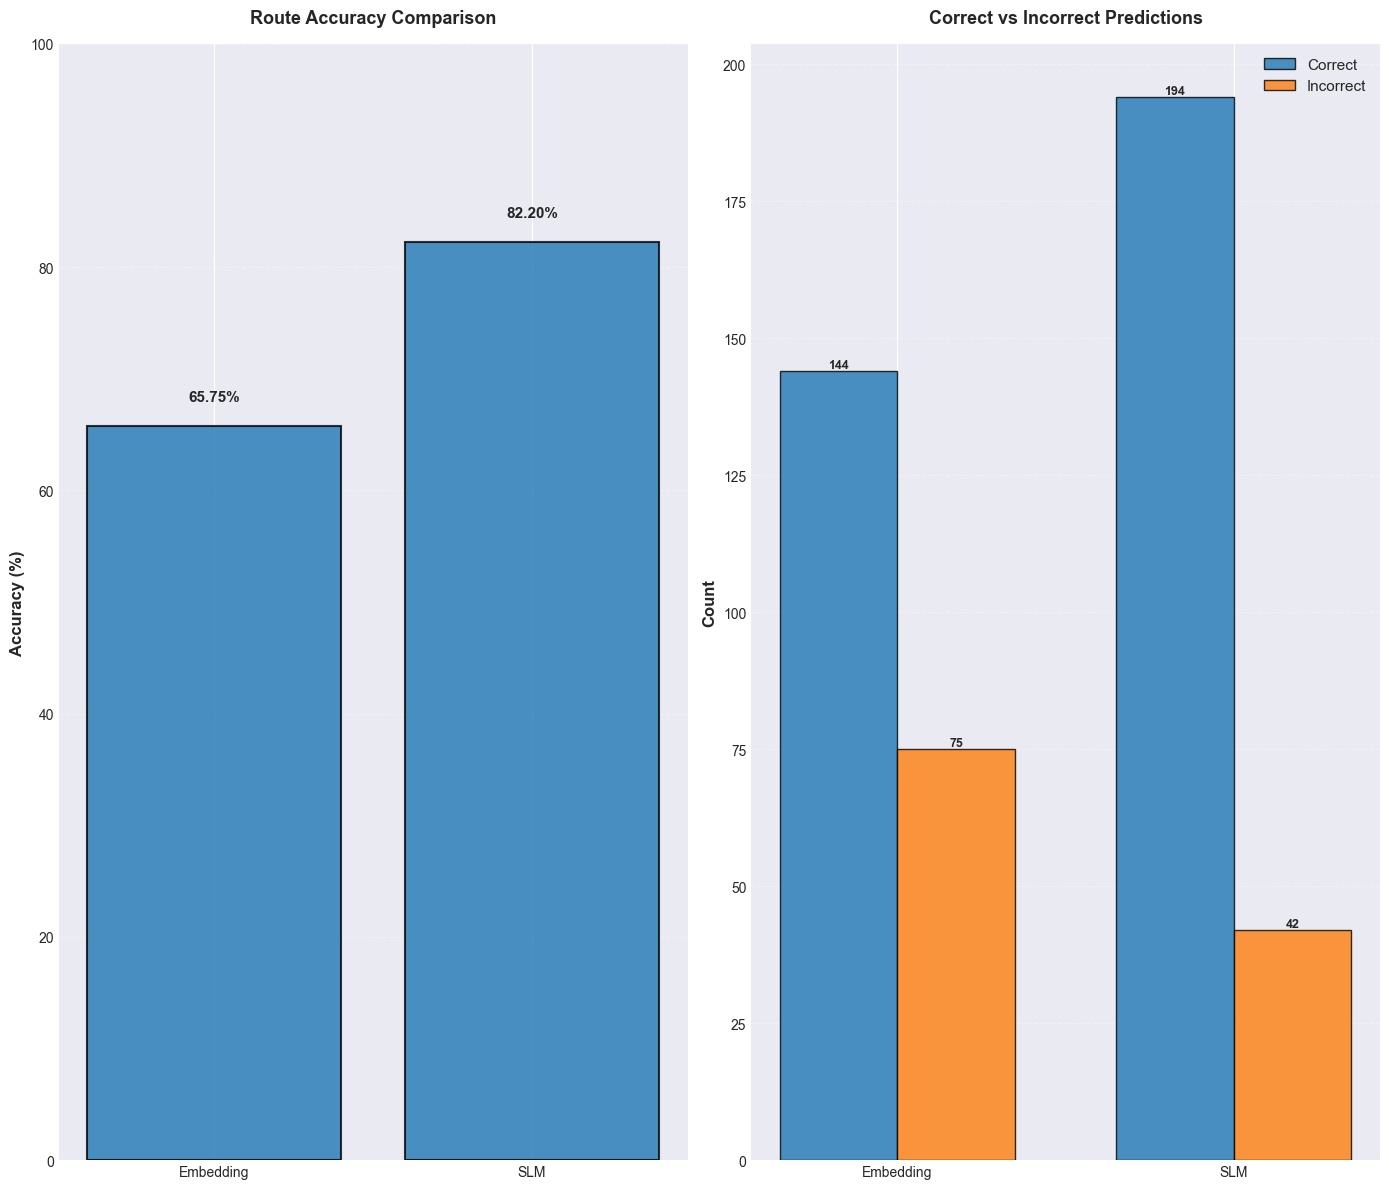

In [55]:

# 2. Route Comparison Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12))

routes = ['Embedding', 'SLM']
summaries = [embedding_summary, slm_summary]
accuracies = [s.get('accuracy', 0) if s.get('accuracy') is not None else 0 for s in summaries]
corrects = [s.get('correct', 0) for s in summaries]
incorrects = [s.get('incorrect', 0) for s in summaries]

# Accuracy comparison
bars1 = ax1.bar(routes, accuracies, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Route Accuracy Comparison', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Correct vs Incorrect comparison
x = np.arange(len(routes))
width = 0.35
bars2 = ax2.bar(x - width/2, corrects, width, label='Correct', alpha=0.8, edgecolor='black')
bars3 = ax2.bar(x + width/2, incorrects, width, label='Incorrect', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Correct vs Incorrect Predictions', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(routes)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

In [56]:
def plot_confusion(df, title, ax):
    valid = df[(df['expected_intent'] != 'N/A') & (df['predicted_intent'] != 'N/A')]
    if valid.empty:
        ax.set_title("No valid rows", fontsize=14)
        return None

    expected = valid['expected_intent']
    predicted = valid['predicted_intent']
    labels = sorted(set(expected) | set(predicted))

    cm = confusion_matrix(expected, predicted, labels=labels)

    im = ax.imshow(cm, cmap='Blues', aspect='auto', interpolation='nearest')
    ax.grid(False)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels([s.replace('_',' ').title() for s in labels], rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels([s.replace('_',' ').title() for s in labels], fontsize=10)

    thresh = cm.max() / 2 if cm.max() else 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, int(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black',
                    fontweight='bold')

    ax.set_xlabel("Predicted Intent", fontsize=12, fontweight='bold')
    ax.set_ylabel("Expected Intent", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')

    return im

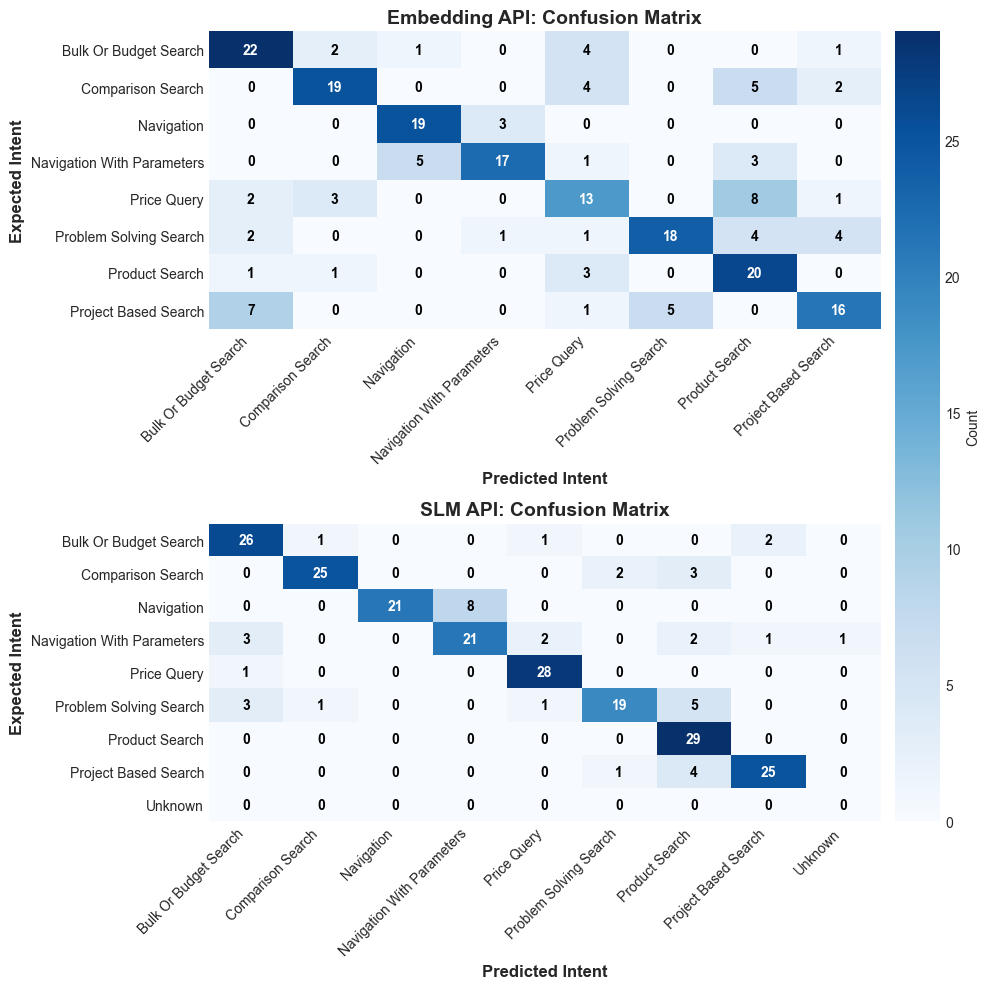

In [57]:
fig = plt.figure(figsize=(10, 10))

# GridSpec: col1 = 90% width, col2 = 10% width
gs = fig.add_gridspec(2, 2, width_ratios=[15, 1])

ax1 = fig.add_subplot(gs[0, 0])  # row 0, col 0
ax2 = fig.add_subplot(gs[1, 0])  # row 1, col 0
cax = fig.add_subplot(gs[:, 1])  # both rows, column 1 (colorbar)

# Plot both matrices
im1 = plot_confusion(df_embedding, "Embedding API: Confusion Matrix", ax1)
im2 = plot_confusion(df_slm, "SLM API: Confusion Matrix", ax2)

# Choose image for colorbar
im_for_colorbar = im2 or im1

# Combined colorbar spanning both rows
fig.colorbar(im_for_colorbar, cax=cax, label="Count")

plt.tight_layout()
plt.show()

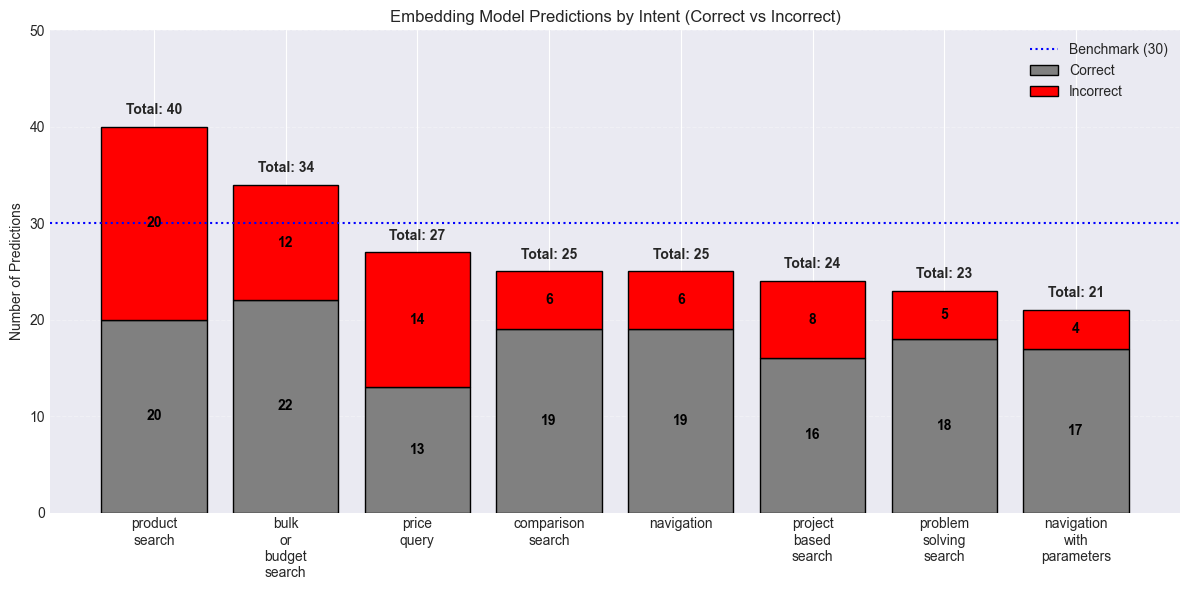

In [58]:
# Embedding model: per-intent bars (predicted vs. accuracy counts with benchmark)
from collections import defaultdict

predicted_totals = defaultdict(int)
predicted_correct = defaultdict(int)

for res in embedding_results:
    predicted = res.get('predictedIntent')
    if not predicted or predicted == 'N/A':
        continue
    predicted_totals[predicted] += 1
    if res.get('isCorrect') is True:
        predicted_correct[predicted] += 1

if predicted_totals:
    intents = sorted(predicted_totals.keys(), key=lambda k: predicted_totals[k], reverse=True)
    correct_counts = [predicted_correct[intent] for intent in intents]
    totals = [predicted_totals[intent] for intent in intents]
    incorrect_counts = [total - correct for total, correct in zip(totals, correct_counts)]

    x = np.arange(len(intents))
    fig, ax = plt.subplots(figsize=(12, 6))

    bars_correct = ax.bar(x, correct_counts, label='Correct', color='gray', edgecolor='black')
    bars_incorrect = ax.bar(x, incorrect_counts, bottom=correct_counts, label='Incorrect', color='red', edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels([intent.replace('_', '\n') for intent in intents], rotation=0)
    ax.set_ylabel('Number of Predictions')
    ax.set_title('Embedding Model Predictions by Intent (Correct vs Incorrect)')

    max_total = max(max(totals), 30)
    ax.set_ylim(0, max_total + 10)
    ax.axhline(30, color='blue', linestyle=':', linewidth=1.5, label='Benchmark (30)')

    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for idx, bar in enumerate(bars_correct):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height / 2,
                f"{correct_counts[idx]}",
                ha='center',
                va='center',
                color='black',
                fontweight='bold'
            )

    for idx, bar in enumerate(bars_incorrect):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{incorrect_counts[idx]}",
                ha='center',
                va='center',
                color='black',
                fontweight='bold'
            )

    for idx, total in enumerate(totals):
        ax.text(
            x[idx],
            total + 1,
            f"Total: {total}",
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()
else:
    print('No predicted intent statistics available to plot.')

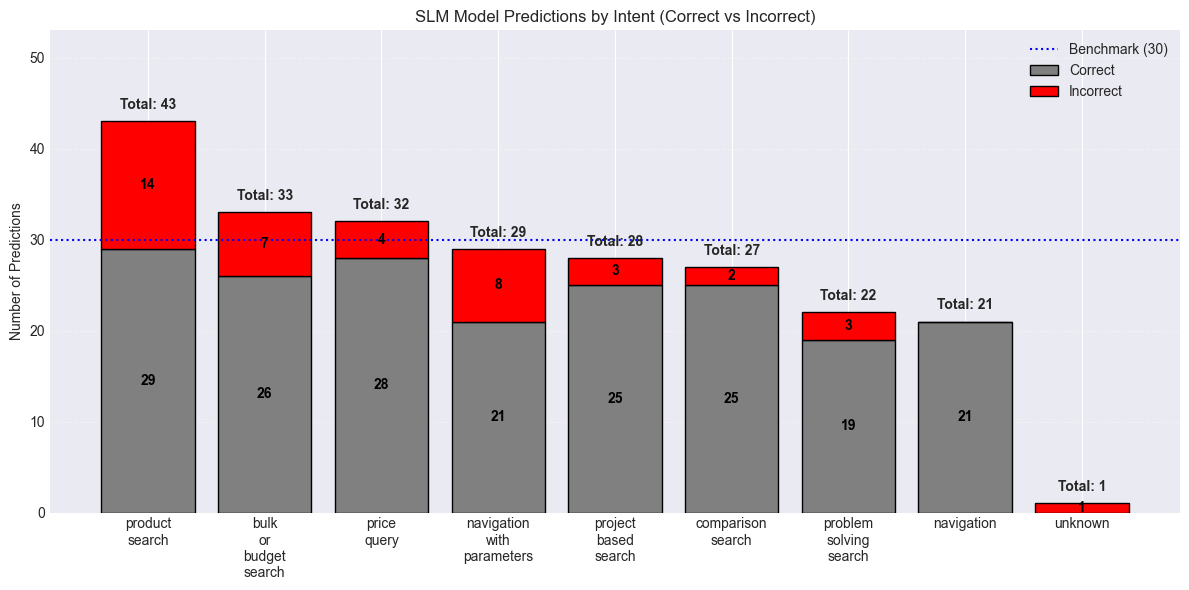

In [59]:
# SLM model: per-intent bars (predicted vs. accuracy counts with benchmark)
from collections import defaultdict

predicted_totals = defaultdict(int)
predicted_correct = defaultdict(int)

for res in slm_results:
    predicted = res.get('predictedIntent')
    if not predicted or predicted == 'N/A':
        continue
    predicted_totals[predicted] += 1
    if res.get('isCorrect') is True:
        predicted_correct[predicted] += 1

if predicted_totals:
    intents = sorted(predicted_totals.keys(), key=lambda k: predicted_totals[k], reverse=True)
    correct_counts = [predicted_correct[intent] for intent in intents]
    totals = [predicted_totals[intent] for intent in intents]
    incorrect_counts = [total - correct for total, correct in zip(totals, correct_counts)]

    x = np.arange(len(intents))
    fig, ax = plt.subplots(figsize=(12, 6))

    bars_correct = ax.bar(x, correct_counts, label='Correct', color='gray', edgecolor='black')
    bars_incorrect = ax.bar(x, incorrect_counts, bottom=correct_counts, label='Incorrect', color='red', edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels([intent.replace('_', '\n') for intent in intents], rotation=0)
    ax.set_ylabel('Number of Predictions')
    ax.set_title('SLM Model Predictions by Intent (Correct vs Incorrect)')

    max_total = max(max(totals), 30)
    ax.set_ylim(0, max_total + 10)
    ax.axhline(30, color='blue', linestyle=':', linewidth=1.5, label='Benchmark (30)')

    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for idx, bar in enumerate(bars_correct):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height / 2,
                f"{correct_counts[idx]}",
                ha='center',
                va='center',
                color='black',
                fontweight='bold'
            )

    for idx, bar in enumerate(bars_incorrect):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{incorrect_counts[idx]}",
                ha='center',
                va='center',
                color='black',
                fontweight='bold'
            )

    for idx, total in enumerate(totals):
        ax.text(
            x[idx],
            total + 1,
            f"Total: {total}",
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()
else:
    print('No predicted intent statistics available to plot.')

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.max_colwidth', None):
    display(df_embedding[df_embedding["is_correct"]==False])

,text,expected_intent,predicted_intent,is_correct,score,error
6,pintura esmalte negro,product_search,comparison_search,False,0.732382,
7,bloques de hormigón 15x20x40,product_search,price_query,False,0.724716,
8,cinta masking para pintura,product_search,bulk_or_budget_search,False,0.738425,
9,tubo hdpe 32mm,product_search,price_query,False,0.831191,
22,cemento portland tipo I 50kg,product_search,price_query,False,0.852669,
25,estoy buscando algo 60x60 antideslizante para exterior pero no sé si es cerámica o porcelanato lo que debería pedir,problem_solving_search,product_search,False,0.898904,
26,"pintura blanca barata… pero que sea lavable, ¿cuál recomiendas?",problem_solving_search,product_search,False,0.757618,
27,tubería 1 pulgada… ¿pero cuál sirve para caliente?,problem_solving_search,product_search,False,0.779346,
34,"aislar ruido sin gastar mucho, ¿qué material sirve?",problem_solving_search,project_based_search,False,0.731253,
43,qué usar para sellar filtraciones,problem_solving_search,navigation_with_parameters,False,0.766942,


In [61]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.max_colwidth', None):
    display(df_slm[df_slm["is_correct"]==False])

,text,expected_intent,predicted_intent,is_correct,score,error
30,estoy buscando algo 60x60 antideslizante para exterior pero no sé si es cerámica o porcelanato lo que debería pedir,problem_solving_search,product_search,False,0,
31,"pintura blanca barata… pero que sea lavable, ¿cuál recomiendas?",problem_solving_search,bulk_or_budget_search,False,0,
32,tubería 1 pulgada… ¿pero cuál sirve para caliente?,problem_solving_search,comparison_search,False,0,
39,"aislar ruido sin gastar mucho, ¿qué material sirve?",problem_solving_search,bulk_or_budget_search,False,0,
44,aislamiento acústico para paredes delgadas,problem_solving_search,product_search,False,0,
50,material para impermeabilizar terraza y también el precio,problem_solving_search,bulk_or_budget_search,False,0,
52,producto para paredes húmedas,problem_solving_search,product_search,False,0,
55,material para terrazza impermeabilização,problem_solving_search,product_search,False,0,
57,precio de pintura y cuál dura más en interior húmedo,problem_solving_search,price_query,False,0,
59,quiero material para nivelar un piso súper desnivelado y también saber cuánto podría costarme más o menos,problem_solving_search,product_search,False,0,


In [74]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.max_colwidth', None):
    print(df_slm.iloc[182])

text                                                                                                                                  Muéstrame mis pedidos
expected_intent                                                                                                                                  navigation
predicted_intent                                                                                                                 navigation_with_parameters
is_correct                                                                                                                                            False
score                                                                                                                                                     0
error                                                                                                                                                      
raw_result          {'intent': 'navigation_with_parameters', 'co

In [76]:
df_slm[df_slm["is_correct"]==False]['text'].to_clipboard()